# Which Economic Tasks are Performed with AI? Evidence from Millions of Claude Conversations

_Handa et al., 2025_

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap
import numpy as np

palette = sns.color_palette("colorblind")

### Create O*NET / SOC Merged Dataframe

In [2]:
def merge_onet_soc_data() -> pd.DataFrame:
    """
    Merges O*NET task statements with SOC (Standard Occupational Classification) data
    based on major group codes.
    
    Args:
        onet_path (str): Path to the O*NET task statements CSV file
        soc_path (str): Path to the SOC structure CSV file
    
    Returns:
        pd.DataFrame: Merged DataFrame containing O*NET data with SOC major group titles
    """

    # Read and process O*NET data
    onet_df = pd.read_csv("onet_task_statements.csv")
    onet_df["soc_major_group"] = onet_df["O*NET-SOC Code"].str[:2]
    
    # Read and process SOC data
    soc_df = pd.read_csv("SOC_Structure.csv")
    soc_df = soc_df.dropna(subset=['Major Group'])
    soc_df["soc_major_group"] = soc_df["Major Group"].str[:2]
    
    # Merge datasets
    merged_df = onet_df.merge(
        soc_df[['soc_major_group', 'SOC or O*NET-SOC 2019 Title']],
        on='soc_major_group',
        how='left'
    )

    return merged_df

In [3]:
task_occupations_df = merge_onet_soc_data()

In [4]:
task_occupations_df["Title"].nunique()

974

In [5]:
# Update cluster mappings to include data from the merged_df
task_occupations_df["task_normalized"] = task_occupations_df["Task"].str.lower().str.strip()
# Some tasks are included multiple times, so we need to count the number of occurrences per task
task_occupations_df["n_occurrences"] = task_occupations_df.groupby("task_normalized")["Title"].transform("nunique")

task_occupations_df

,O*NET-SOC Code,Title,Task ID,Task,Task Type,Incumbents Responding,Date,Domain Source,soc_major_group,SOC or O*NET-SOC 2019 Title,task_normalized,n_occurrences
0,11-1011.00,Chief Executives,8823,Direct or coordinate an organization's financi...,Core,87.0,07/2014,Incumbent,11,Management Occupations,direct or coordinate an organization's financi...,1
1,11-1011.00,Chief Executives,8831,Appoint department heads or managers and assig...,Core,87.0,07/2014,Incumbent,11,Management Occupations,appoint department heads or managers and assig...,1
2,11-1011.00,Chief Executives,8825,Analyze operations to evaluate performance of ...,Core,87.0,07/2014,Incumbent,11,Management Occupations,analyze operations to evaluate performance of ...,1
3,11-1011.00,Chief Executives,8826,"Direct, plan, or implement policies, objective...",Core,87.0,07/2014,Incumbent,11,Management Occupations,"direct, plan, or implement policies, objective...",1
4,11-1011.00,Chief Executives,8827,"Prepare budgets for approval, including those ...",Core,87.0,07/2014,Incumbent,11,Management Occupations,"prepare budgets for approval, including those ...",1
...,...,...,...,...,...,...,...,...,...,...,...,...
19525,53-7121.00,"Tank Car, Truck, and Ship Loaders",12806,"Test vessels for leaks, damage, and defects, a...",Supplemental,66.0,12/2006,Incumbent,53,Transportation and Material Moving Occupations,"test vessels for leaks, damage, and defects, a...",1
19526,53-7121.00,"Tank Car, Truck, and Ship Loaders",12807,Unload cars containing liquids by connecting h...,Supplemental,66.0,12/2006,Incumbent,53,Transportation and Material Moving Occupations,unload cars containing liquids by connecting h...,1
19527,53-7121.00,"Tank Car, Truck, and Ship Loaders",12808,Copy and attach load specifications to loaded ...,Supplemental,64.0,12/2006,Incumbent,53,Transportation and Material Moving Occupations,copy and attach load specifications to loaded ...,1
19528,53-7121.00,"Tank Car, Truck, and Ship Loaders",12809,Start pumps and adjust valves or cables to reg...,Supplemental,67.0,12/2006,Incumbent,53,Transportation and Material Moving Occupations,start pumps and adjust valves or cables to reg...,1


### Load Task Mappings and Join

In [6]:
task_mappings_df = pd.read_csv("onet_task_mappings.csv")

In [7]:
grouped_with_occupations = task_mappings_df.merge(
    task_occupations_df,
    left_on="task_name",
    right_on="task_normalized",
    how="left"
)

grouped_with_occupations["pct_occ_scaled"] = 100 * (grouped_with_occupations["pct"] / grouped_with_occupations["n_occurrences"]) / (grouped_with_occupations["pct"] / grouped_with_occupations["n_occurrences"]).sum()
grouped_with_occupations["pct_occ_scaled"].sum()

np.float64(100.0)

In [8]:
grouped_with_occupations

,task_name,pct,O*NET-SOC Code,Title,Task ID,Task,Task Type,Incumbents Responding,Date,Domain Source,soc_major_group,SOC or O*NET-SOC 2019 Title,task_normalized,n_occurrences,pct_occ_scaled
0,act as advisers to student organizations.,0.006775,25-1011.00,"Business Teachers, Postsecondary",5682.0,Act as advisers to student organizations.,Core,95.0,07/2011,Incumbent,25,Educational Instruction and Library Occupations,act as advisers to student organizations.,34.0,0.000200
1,act as advisers to student organizations.,0.006775,25-1021.00,"Computer Science Teachers, Postsecondary",5700.0,Act as advisers to student organizations.,Supplemental,58.0,07/2011,Incumbent,25,Educational Instruction and Library Occupations,act as advisers to student organizations.,34.0,0.000200
2,act as advisers to student organizations.,0.006775,25-1022.00,"Mathematical Science Teachers, Postsecondary",5726.0,Act as advisers to student organizations.,Supplemental,107.0,07/2011,Incumbent,25,Educational Instruction and Library Occupations,act as advisers to student organizations.,34.0,0.000200
3,act as advisers to student organizations.,0.006775,25-1031.00,"Architecture Teachers, Postsecondary",5751.0,Act as advisers to student organizations.,Supplemental,72.0,07/2011,Incumbent,25,Educational Instruction and Library Occupations,act as advisers to student organizations.,34.0,0.000200
4,act as advisers to student organizations.,0.006775,25-1032.00,"Engineering Teachers, Postsecondary",5774.0,Act as advisers to student organizations.,Supplemental,70.0,07/2011,Incumbent,25,Educational Instruction and Library Occupations,act as advisers to student organizations.,34.0,0.000200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4240,"write, design, or edit web page content, or di...",0.320908,15-1134.00,Web Developers,14696.0,"Write, design, or edit Web page content, or di...",Core,30.0,06/2008,Occupational Expert,15,Computer and Mathematical Occupations,"write, design, or edit web page content, or di...",1.0,0.322461
4241,"write, present, and publish reports that recor...",0.117393,19-3091.02,Archeologists,9155.0,"Write, present, and publish reports that recor...",Core,33.0,07/2012,Occupational Expert,19,"Life, Physical, and Social Science Occupations","write, present, and publish reports that recor...",1.0,0.117961
4242,"write, review, or execute plans for testing ne...",0.010944,15-1199.12,Document Management Specialists,16220.0,"Write, review, or execute plans for testing ne...",Core,25.0,07/2013,Occupational Expert,15,Computer and Mathematical Occupations,"write, review, or execute plans for testing ne...",1.0,0.010997
4243,"write, review, or maintain engineering documen...",0.076872,17-2141.02,Automotive Engineers,16425.0,"Write, review, or maintain engineering documen...",Core,23.0,07/2014,Occupational Expert,17,Architecture and Engineering Occupations,"write, review, or maintain engineering documen...",1.0,0.077244


### OCCUPATIONS

In [9]:
grouped_with_occupations.groupby("Title")["pct_occ_scaled"].sum()

Title
Accountants                           0.401014
Actors                                0.784222
Actuaries                             0.064806
Acupuncturists                        0.028148
Acute Care Nurses                     0.040062
                                        ...   
Wind Energy Engineers                 0.002880
Wind Energy Operations Managers       0.008903
Wind Energy Project Managers          0.014794
Word Processors and Typists           0.415677
Zoologists and Wildlife Biologists    0.039800
Name: pct_occ_scaled, Length: 756, dtype: float64

/var/folders/31/rr3vvs0x69v0hzh5y29651200000gn/T/ipykernel_18096/1992135786.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['\n'.join(wrap(label.get_text(), width=40))


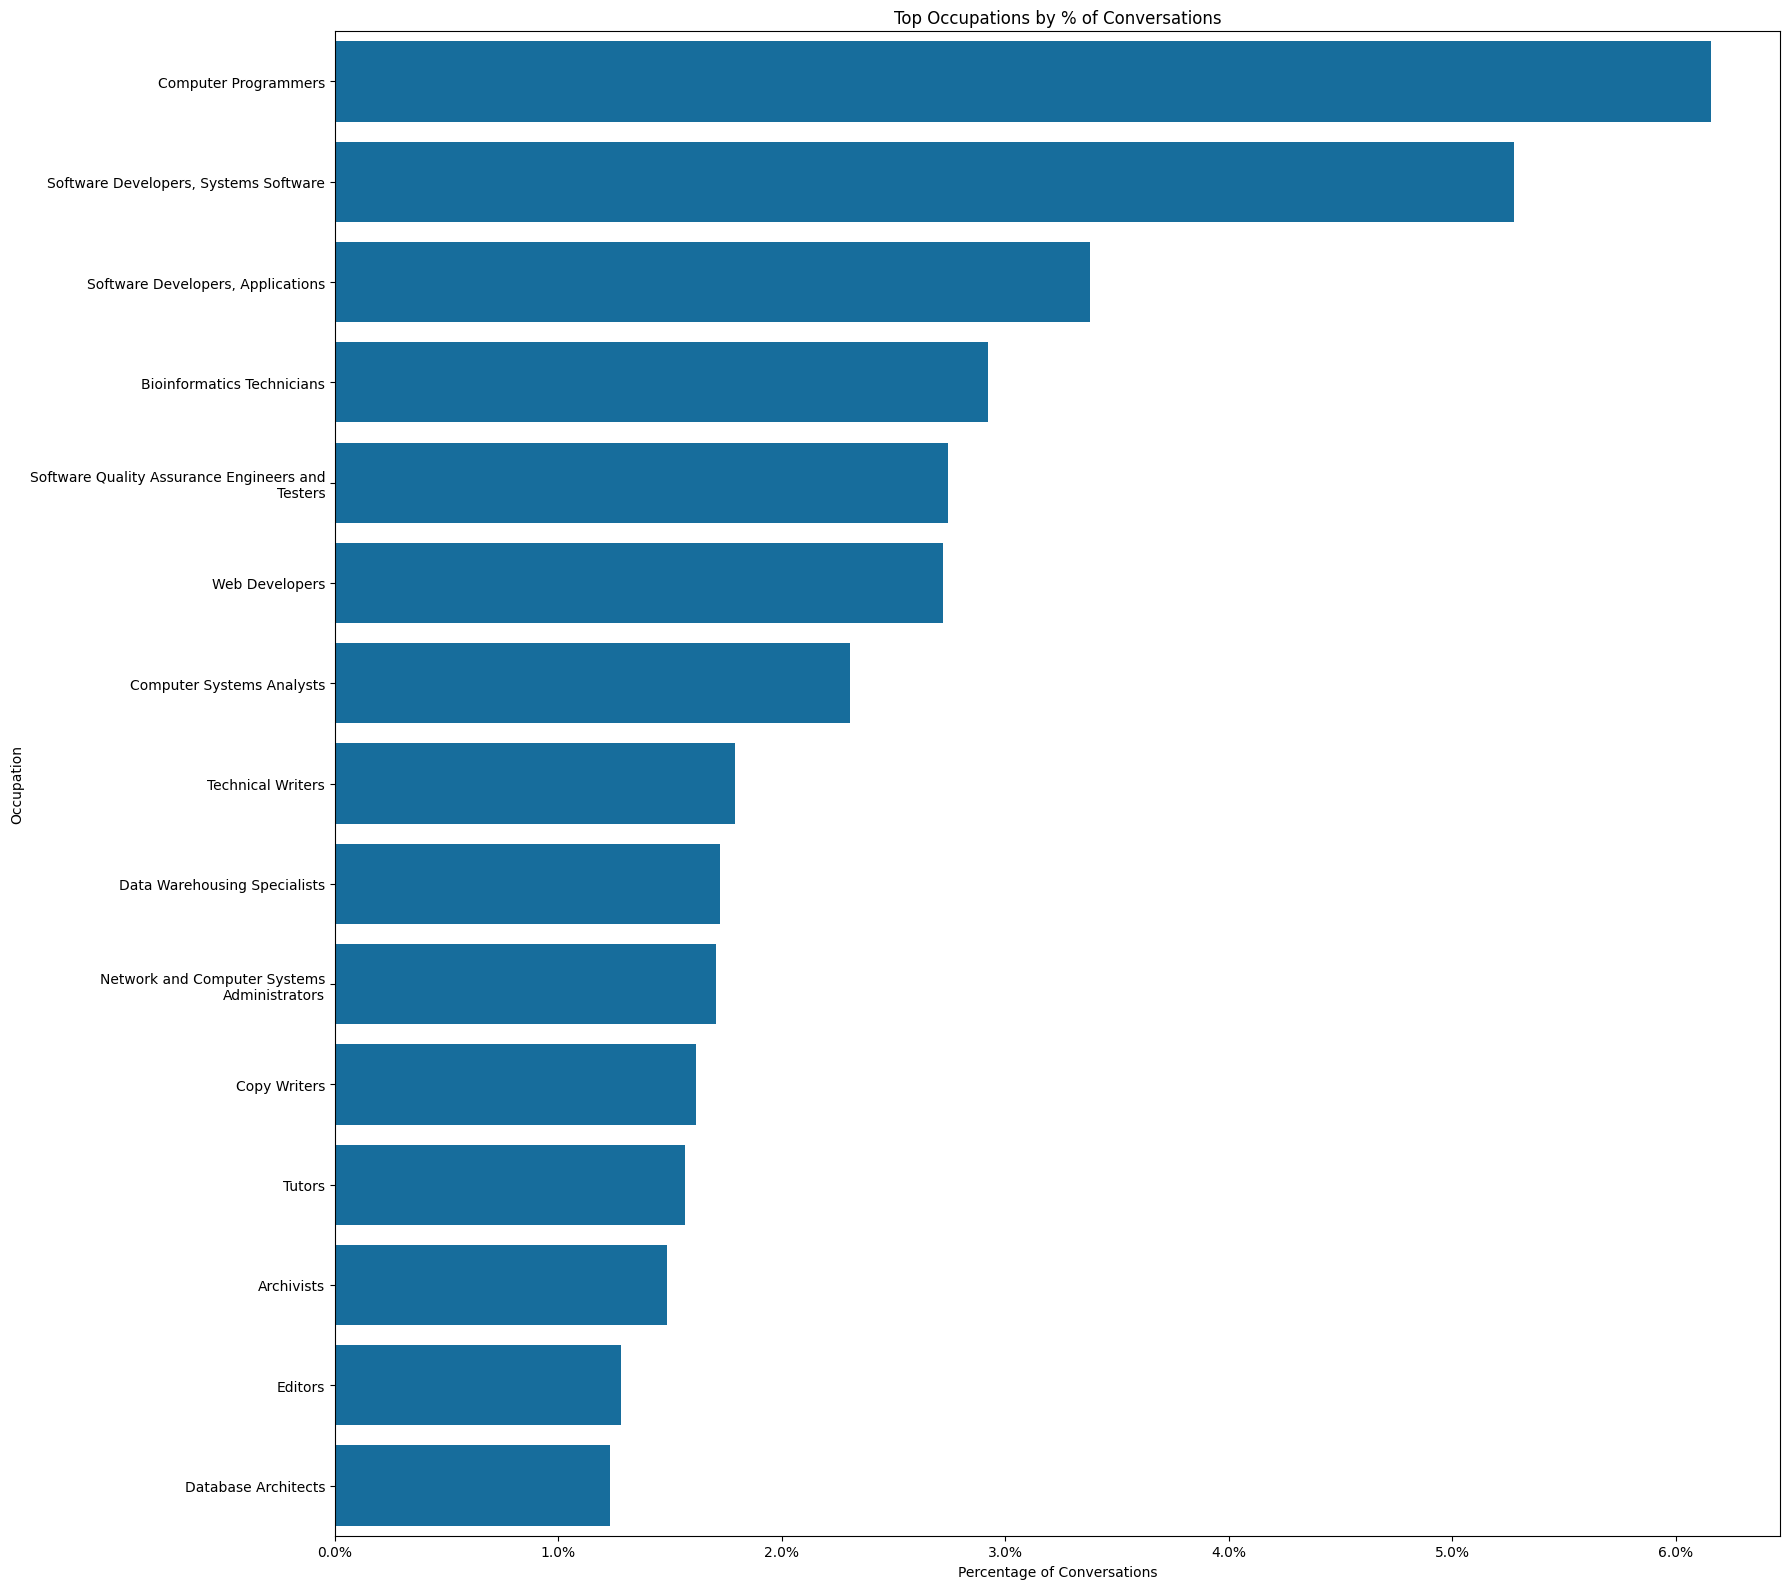

In [10]:
# Calculate percentages per group and occupation
plot_df = (grouped_with_occupations.groupby("Title")["pct_occ_scaled"]
           .sum()
           .reset_index())

# Get top occupations overall
total_occs = (plot_df.groupby("Title")["pct_occ_scaled"]
              .sum()
              .sort_values(ascending=False))
top_occs = total_occs.head(15).index

# Filter for top occupations
plot_df = plot_df[plot_df["Title"].isin(top_occs)]

# Sort occupations by overall frequency
occ_order = (plot_df.groupby("Title")["pct_occ_scaled"]
             .sum()
             .sort_values(ascending=False)
             .index)
plot_df["Title"] = pd.Categorical(plot_df["Title"], categories=occ_order, ordered=True)

# Create the plot
plt.figure(figsize=(18, 16))
sns.barplot(
    data=plot_df,
    x="pct_occ_scaled",
    y="Title",
    color=palette[0],
)

# Wrap occupation titles
ax = plt.gca()
ax.set_yticklabels(['\n'.join(wrap(label.get_text(), width=40)) 
                    for label in ax.get_yticklabels()])

# Format x-axis as percentages
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}%'))

# Customize the plot
plt.title('Top Occupations by % of Conversations')
plt.xlabel('Percentage of Conversations')
plt.ylabel('Occupation')

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()